In [861]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import plotly.express as px

import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
# from geopy.geocoders import Nominatim 
# from geopy.distance import geodesic

# Данные

In [862]:
path = '../data/_data.csv'
df = pd.read_csv(path)
pd.set_option('display.max_columns', None)

In [863]:
df.drop(['Unnamed: 0','Тип', 'Телефоны', 'Ссылка на объявление', 'Серия дома' ], axis= 1, inplace=True)

In [864]:
# убираем адреса не в Мск
df = df[df['Адрес'].str.contains('Москва')]
# Оставляем только те, где цена указана в рублях
# df = df[df['Цена'].str.contains('руб.')]


In [865]:
# для подсчета количества пропущенных значений в каждом столбце
df.iloc[:, 7:12].isna().sum()

Цена                     0
Описание                 0
Ремонт                2463
Площадь комнат, м2    7228
Балкон                6630
dtype: int64

In [866]:
df.isna().sum()

ID  объявления                  0
Количество комнат             535
Метро                         346
Адрес                           0
Площадь, м2                     0
Дом                             0
Парковка                    11174
Цена                            0
Описание                        0
Ремонт                       2463
Площадь комнат, м2           7228
Балкон                       6630
Окна                         5150
Санузел                      2041
Можно с детьми/животными     4915
Дополнительно                 272
Название ЖК                 15281
Высота потолков, м           9202
Лифт                         4192
Мусоропровод                 8007
dtype: int64

# Релиз 2.0

### Площадь комнат

In [867]:
# вытаскиваем данные о площади комнат из площади квартиры по 2 индексу 
room_areas = df['Площадь, м2'].str.split('/').apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
df.loc[df['Площадь комнат, м2'].isna(), 'Площадь комнат, м2'] = room_areas
missing_indices = df['Площадь комнат, м2'].isna()
df.loc[missing_indices, 'Площадь комнат, м2'] = df.loc[missing_indices, 'Площадь, м2'].str.split('/').str[0]


In [868]:
df['Площадь комнат, м2'].isna().sum()

0

### Количество комнат

In [869]:
# Для заполнения пропущенных значений в столбце "Количество комнат" нам потребуется создать временные столбцы


# На сайте видно, что на первом месте заспличенного столбца "Площадь, м2" всегда общая площадь
df['total_area'] = df['Площадь, м2'].apply(lambda x: float(x.split('/')[0]))

# Заменим NaN на строковые значения, чтобы затем создать еще один временный столбец с количеством комнат, куда будем складывать результаты вычислений
df['Количество комнат'].fillna('Unknown', inplace=True)

df['rooms_num'] = df['Количество комнат'].apply(lambda x: int(x.split(',')[0]) if x != 'Unknown' else x)

# В некоторых строках с незаполненным количеством комнат, указаны площади комнат. Посчитаем количество площадей - это и будет количеством комнат
df['area_based_room_num'] = df['Площадь комнат, м2'].apply(lambda x: len(x.split()) if isinstance(x, str) else x)

# Создадим фильтр и занесем посчиатнные значения во временный столбец
mask = (df['rooms_num'] == 'Unknown') & (~df['area_based_room_num'].isna())
df.loc[mask, 'rooms_num'] = df.loc[mask, 'area_based_room_num']

# Находим строки, где значение столбца 'rooms_num' неизвестно, а в 'Описании' упоминается "студия" или "однокомнатность",
# и присваиваем им значение 1 в столбце 'rooms_num'
df.loc[(df['rooms_num'] == 'Unknown') & (df['Описание'].str.contains('студи|однок', case=False)), 'rooms_num'] = 1
df['rooms_num'].value_counts()

/var/folders/vb/3hggmwrs7794d_7wkqtk7xtm0000gn/T/ipykernel_26728/3178003716.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





rooms_num
2    7407
1    7190
3    3668
4    1011
5     333
6     128
Name: count, dtype: int64

In [870]:
# Осталось совсем немного неизвестных значений, поэтому оставшиеся заполним опираясь на медианную площадь
df[df['rooms_num'] != 'Unknown'][['rooms_num', 'total_area']].groupby('rooms_num').agg({'total_area': 'median'})

,total_area
rooms_num,
1,37
2,52
3,80
4,145
5,206
6,330


In [871]:
df.loc[(df['rooms_num'] == 'Unknown') & (df['total_area'] < 52), 'rooms_num'] = 1
df.loc[(df['rooms_num'] == 'Unknown') & ~(df['total_area'] < 52), 'rooms_num'] = 2

In [872]:
# Теперь заполним пропущенные значения в столбец Количество комнат

df.loc[df['Количество комнат'] == 'Unknown', 'Количество комнат'] = df.loc[df['Количество комнат'] == 'Unknown', 'rooms_num']
df['Количество комнат'].isna().sum()

0

### Метро

In [873]:
# Применим тот же подход, что и на предыдущем шаге

df['Метро'] = df['Метро'].fillna('Unknown')

df['metro'] = df['Метро'].apply(lambda x: x.split('(')[0])

In [874]:
# При изучении датафрейма оказалось, что большое кол-во пропущенных станций метро приходятся на Зеленоград. Заменим их на 
# ближайшее метро
df.loc[(df['metro'] == 'Unknown') & (df['Адрес'].str.contains('зеленогр', case=False)), 'metro'] = 'Ховрино (25 мин на машине)'
df['metro'].isna().sum()

0

### Парковка

In [875]:
# Применим тот же подход, что и на предыдущем шаге. К третьему релизу проанализируем влияет ли наличие информации о парковке 
# на стоимость аренды
df['Парковка'] = df['Парковка'].fillna('Unknown')

In [876]:
df['Парковка'].isna().sum()

0

In [877]:
# Если в столбце 'Название ЖК' есть записи, заполняем пропущенные значения в столбце 'Парковка' значением 'есть'
##df.loc[df['Название ЖК'].notnull() & df['Парковка'].isna(), 'Парковка'] = 'есть'

# Заполняем пропущенные значения в столбце 'Парковка' значением 'нет'

#df['Парковка'] = df['Парковка'].fillna('нет')
#df['Парковка'].isna().sum()

In [878]:
#df['Парковка'].value_counts()

In [879]:
# Заменяем все значения, кроме 'нет', на 'есть'
# df['Парковка'] = df['Парковка'].replace(['наземная', 'подземная', 'есть', 'открытая', 'многоуровневая', 'на крыше'], 'есть')
# df['Парковка'].value_counts() 

### Ремонт

In [880]:
df['Ремонт'].value_counts()

Ремонт
Косметический    7361
Евроремонт       7004
Дизайнерский     2773
Без ремонта       136
Name: count, dtype: int64

In [881]:
# Заменим на моду 
df['Ремонт'] = df['Ремонт'].fillna(df['Ремонт'].mode()[0])
df.fillna({'Ремонт': df['Ремонт'].mode()[0]}, inplace=True)

In [882]:
# или заменим на Не указан
# df['Ремонт']= df['Ремонт']fillna('Не указано')

In [883]:
df['Ремонт'].isna().sum()

0

### Балкон 

In [884]:
df['Балкон'].describe()

count          13107
unique            18
top       Балкон (1)
freq            6336
Name: Балкон, dtype: object

In [885]:
#Количество пропусков в столбце с Балконом
df['Балкон'].isna().value_counts()

Балкон
False    13107
True      6630
Name: count, dtype: int64

In [886]:
df['Балкон'].value_counts()

Балкон
Балкон (1)                6336
Лоджия (1)                5032
Балкон (1), Лоджия (1)     610
Лоджия (2)                 537
Балкон (2)                 423
Балкон (3)                  45
Лоджия (3)                  42
Балкон (1), Лоджия (2)      21
Балкон (2), Лоджия (2)      21
Балкон (2), Лоджия (1)      16
Лоджия (4)                   5
Балкон (3), Лоджия (1)       4
Балкон (4)                   4
Балкон (1), Лоджия (3)       4
Балкон (2), Лоджия (3)       3
Балкон (1), Лоджия (4)       2
Балкон (3), Лоджия (3)       1
Балкон (4), Лоджия (4)       1
Name: count, dtype: int64

In [887]:
#Функция для заполнения пропусков в столбце Балкон на самые часто встречающиеся значение - Балкон(1) и Лоджия(1)
def notna_balcony(row):
    if pd.isna(row['Балкон']): 
        floor = int(re.findall(r'\d+', row['Дом'])[0])  # Получаем первый найденный этаж
        type_of_house = row['Дом'].split(',')[-1].strip()  # Убираем лишние пробелы
        area = float(row['Площадь, м2'].split('/')[0])
        if floor > 3 and area > 100 and type_of_house != 'Монолитный':
            return 'Балкон (1)'
        else:
            return 'Лоджия (1)'
    else:
        return row['Балкон']
    
df['Балкон'] = df.apply(notna_balcony, axis=1)
df['Балкон'].isna().sum()

0

### Окна

In [888]:
#Сколько раз встречаются уникальные значения в столбце Окна
df['Окна'].value_counts()

Окна
Во двор            9708
На улицу и двор    2762
На улицу           2117
Name: count, dtype: int64

In [889]:
#Количество пропусков в столбце Окна
df['Окна'].isna().value_counts()

Окна
False    14587
True      5150
Name: count, dtype: int64

In [890]:
#Согласно анализу объявлений, если в описании присутствует фраза "вид на", то, как правило вид из окон на достопримечательность, что сыграет роль в стоимости аренды
#Функция для заполнения значений по описанию:
def from_description(row):
    if pd.isna(row['Окна']) and 'вид на' in row['Описание'].lower():
        return 'На достопримечательность'
    
    elif pd.isna(row['Окна']) and 'вид во' in row['Описание'].lower():
        return 'Во двор'
    else:
        return row['Окна']

df['Окна'] = df.apply(from_description, axis=1)

In [891]:
df['Окна'].value_counts()

Окна
Во двор                     9712
На улицу и двор             2762
На улицу                    2117
На достопримечательность     138
Name: count, dtype: int64

In [892]:
#Функция для заполнения пропусков в столбце Окна в зависимости от этажа
def from_floor(row):
    if pd.isna(row['Окна']): 
        floor = int(re.findall(r'\d+', row['Дом'])[0])
        if floor < 6:
            return 'Во двор'
    else:
        return row['Окна']    
 
df['Окна'] = df.apply(from_floor, axis=1) 

In [893]:
#Окончательно заполняем пропуски:

# Вычисляем частоту встречания каждого значения в столбце "Окна"
window_counts = df['Окна'].value_counts(normalize=True)

# Заполняем пропуски в столбце "Окна" значениями на основе их частоты встречания
df['Окна'] = df['Окна'].fillna(pd.Series(np.random.choice(window_counts.index, p=window_counts, size=len(df))))
df['Окна'].value_counts()

Окна
Во двор                     13679
На улицу и двор              3144
На улицу                     2414
На достопримечательность      156
Name: count, dtype: int64

In [894]:
# Вычисляем частоту встречания каждого значения
window_counts = df['Окна'].value_counts(normalize=True)
window_counts 

Окна
Во двор                    1
На улицу и двор            0
На улицу                   0
На достопримечательность   0
Name: proportion, dtype: float64

In [895]:
# Генерируем значения для заполнения пропусков
fill_values = np.random.choice(window_counts.index, p=window_counts, size=df['Окна'].isnull().sum())
df.loc[df['Окна'].isnull(), 'Окна'] = fill_values
df['Окна'].isna().sum()

0

### Санузел

In [896]:
df['Санузел'].value_counts()

Санузел
Совмещенный (1)                    8500
Раздельный (1)                     6139
Совмещенный (2)                    1293
Совмещенный (1), Раздельный (1)     730
Раздельный (2)                      401
Совмещенный (3)                     223
Совмещенный (2), Раздельный (1)     179
Совмещенный (4)                      74
Раздельный (3)                       44
Совмещенный (1), Раздельный (2)      28
Совмещенный (3), Раздельный (1)      26
Совмещенный (2), Раздельный (2)      22
Раздельный (4)                       15
Совмещенный (3), Раздельный (3)       6
Совмещенный (4), Раздельный (1)       6
Совмещенный (4), Раздельный (2)       4
Совмещенный (1), Раздельный (3)       2
Совмещенный (2), Раздельный (3)       2
Совмещенный (2), Раздельный (4)       1
Совмещенный (3), Раздельный (2)       1
Name: count, dtype: int64

In [897]:
#Заполним пропуски модой при группировке по количеству комнат:
mode_per_room = df.groupby('Количество комнат')['Санузел'].transform(lambda x: x.mode().iloc[0])
df['Санузел'] = df['Санузел'].fillna(mode_per_room)

In [898]:
df.columns

Index(['ID  объявления', 'Количество комнат', 'Метро', 'Адрес', 'Площадь, м2',
       'Дом', 'Парковка', 'Цена', 'Описание', 'Ремонт', 'Площадь комнат, м2',
       'Балкон', 'Окна', 'Санузел', 'Можно с детьми/животными',
       'Дополнительно', 'Название ЖК', 'Высота потолков, м', 'Лифт',
       'Мусоропровод', 'total_area', 'rooms_num', 'area_based_room_num',
       'metro'],
      dtype='object')

### Можно с детьми/животными

In [899]:
df['Можно с детьми/животными'].isna().value_counts()

Можно с детьми/животными
False    14822
True      4915
Name: count, dtype: int64

In [900]:
df['Можно с детьми/животными'].value_counts()

Можно с детьми/животными
Можно с детьми                       8540
Можно с детьми, Можно с животными    6075
Можно с животными                     207
Name: count, dtype: int64

In [901]:
# Применяем функцию для заполнения пропусков в столбце "Можно с детьми/животными" на основе описания
def fill_children_animals_description(row):
    if pd.isna(row['Можно с детьми/животными']):
        description = row['Описание'].lower()
        if any(word in description for word in ['детск', 'ребен', 'школ', 'семь']):
            if 'нельзя с' not in description:
                return 'Можно с детьми'
            else:
                return 'Нельзя никого'
        elif any(word in description for word in ['питом', 'животн', 'собак', 'кошк', 'пес', 'кот']):
            return 'Можно с животными'
        elif 'нельзя с' in description:
            return 'Нельзя никого'
        else:
            return np.nan
    else:
        return row['Можно с детьми/животными']

df['Можно с детьми/животными'] = df.apply(fill_children_animals_description, axis=1)

In [902]:
# Применяем функцию для заполнения пропусков в столбце "Можно с детьми/животными" на основе площади квартиры
def fill_children_animals_area(row):
    if pd.isna(row['Можно с детьми/животными']):
        if float(row['Площадь, м2'].split('/')[0]) < 50:
            return 'Нельзя никого'
        else:
            return 'Можно с детьми'   #Оставшиеся значения заполняются самым часто встречающимся
    else:
        return row['Можно с детьми/животными']   
            

df['Можно с детьми/животными'] = df.apply(fill_children_animals_area, axis=1)

### Дополнительно

In [903]:
df['Дополнительно'].value_counts()

Дополнительно
Мебель в комнатах, Мебель на кухне, Ванна, Стиральная машина, Телевизор, Холодильник, Интернет                                       2553
Мебель в комнатах, Мебель на кухне, Ванна, Стиральная машина, Холодильник, Интернет                                                  1085
Мебель в комнатах, Мебель на кухне, Ванна, Стиральная машина, Кондиционер, Посудомоечная машина, Телевизор, Холодильник, Интернет     977
Мебель в комнатах, Мебель на кухне, Ванна, Стиральная машина, Кондиционер, Телевизор, Холодильник, Интернет                           906
Мебель в комнатах, Мебель на кухне, Ванна, Стиральная машина, Телевизор, Холодильник, Интернет, Телефон                               859
                                                                                                                                     ... 
Стиральная машина, Кондиционер                                                                                                          1
Мебель в комнатах, М

In [904]:
df['Дополнительно'].isna().value_counts()

Дополнительно
False    19465
True       272
Name: count, dtype: int64

In [905]:
df[df['Описание'].str.contains('без мебели', case=False, na=False)]

,ID объявления,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,"Высота потолков, м",Лифт,Мусоропровод,total_area,rooms_num,area_based_room_num,metro
8,273973191,3,м. Смоленская (9 мин пешком),"Москва, Новинский бульвар, 18С1",120.0/95.0/10.0,"5/10, Сталинский",открытая,"130000.0 руб./ За месяц, Залог - 130000 руб., ...",Лот 71833. Евгений Николаев.\n\nБонус агенту 1...,Евроремонт,45 25 25,Балкон (1),На улицу,Совмещенный (1),Можно с животными,"Мебель на кухне, Ванна, Стиральная машина, Кон...",NaN,3,Пасс (1),Нет,120,3,3,м. Смоленская
19,274748017,"5, Оба варианта",м. Кропоткинская (6 мин пешком),"Москва, Филипповский переулок, 9",201.0/162.0/16.0,3/3,Unknown,"190000.0 руб./ За месяц, Залог - 190000 руб., ...",ID 10903: Просторная 5-комнатная квартира в д...,Евроремонт,24-22-24-28-64,Лоджия (1),На улицу и двор,Совмещенный (3),"Можно с детьми, Можно с животными","Мебель на кухне, Ванна, Душевая кабина, Стирал...",NaN,3,Пасс (1),NaN,201,5,1,м. Кропоткинская
56,274617827,5,м. Кропоткинская (8 мин пешком),"Москва, Филипповский переулок, 9",200.0/150.0/30.0,"3/3, Кирпичный",Unknown,"190000.0 руб./ За месяц, Залог - 190000 руб., ...",Предлагается 5-ти комнатная квартира в отреста...,Евроремонт,30-30-30-30-30,Лоджия (1),Во двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель на кухне, Стиральная машина, Телевизор,...",NaN,NaN,NaN,NaN,200,5,1,м. Кропоткинская
69,271264562,5,м. Кропоткинская (5 мин пешком),"Москва, Гоголевский бульвар, 23",170.0/104.0/21.0,"5/5, старый фонд",наземная,"175000.0 руб./ За месяц, Залог - 175000 руб., ...",Лот 67428. Анастасия Баталова.\n\nБонус агенту...,Евроремонт,14 11 20 48 11,Балкон (1),На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель на кухне, Душевая кабина, Стиральная ма...",NaN,3,Пасс (1),Да,170,5,5,м. Кропоткинская
74,271766412,6,м. Александровский сад (4 мин пешком),"Москва, переулок Романов, 5",228.0/159.0/30.0,3/6,Unknown,"400000.0 руб./ За месяц, Залог - 400000 руб., ...",Лот 30273. Коллегам бонус 50 000 рублей. Татья...,Евроремонт,50+30+19+18+23+19,Балкон (1),Во двор,Совмещенный (2),Можно с детьми,"Мебель на кухне, Душевая кабина, Стиральная ма...",NaN,NaN,Пасс (1),NaN,228,6,1,м. Александровский сад
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22989,274204547,4,м. Сокол (5 мин на машине),"Москва, Иваньковское шоссе, 5",150.0/83.0/15.0,"16/23, Монолитно-кирпичный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",Лот 81033. Ирина Волкова.\n\nБонус агенту 2500...,Евроремонт,19 18 11 35,Балкон (1),На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель на кухне, Ванна, Душевая кабина, Стирал...",NaN,3,"Пасс (1), Груз (1)",Да,150,4,4,м. Сокол
23031,274776175,4,м. Щукинская (19 мин пешком),"Москва, Иваньковское шоссе, 5",150.0/100.0/20.0,16/24,Unknown,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",Лот 69725. Просторная светлая квартира без меб...,Евроремонт,25+20+20+35,Балкон (1),На улицу,Совмещенный (2),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Стиральная...",NaN,NaN,NaN,NaN,150,4,1,м. Щукинская
23132,269188642,4,м. Стрешнево (10 мин на машине),"Москва, Никольский тупик, 2к1",220.0/130.0/20.0,"4/6, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","ЭЛИТНЫЙ ЖК ЧАЙКА с круглосуточной охраной, вид...",Дизайнерский,130.0,Балкон (1),Во двор,Совмещенный (3),"Можно с детьми, Можно с животными","Мебель на кухне, Ванна, Душевая кабина, Стирал...",NaN,NaN,"Пасс (2), Груз (2)",NaN,220,4,1,м. Стрешнево
23133,271992616,"4, Оба варианта",м. Сокол (10 мин на машине),"Москва, Береговая улица, 8К1",203.0/92.0/25.0,1/5,наземная,"600000.0 руб./ За месяц, Залог - 600000 руб., ...","ID 35735: Предлагается превосходная, просторн...",Евроремонт,30-20-20-22,Лоджия (1),На улицу,Совмещенный (2),"Можно с детьми, Можно с животными","Ме

In [906]:
# Применяем функцию для заполнения пропусков в столбце на основе описания
def additional_description(row):
    if pd.isna(row['Дополнительно']):
        description = row['Описание'].lower()
        if any(word in description for word in ['без мебели', 'мебели нет']):
            if any(word in description for word in ['стиральная', 'техникой', 'холодильник', 'оборудована']):
                return 'мебель и техника'  # Обновляем значение на "мебель и техника"
            else:
                return 'ничего'  # Обновляем значение на "ничего"
        elif any(word in description for word in ['частично мебел', 'вся мебель', 'мебель в', 'необходимая', 'необходимой', 'меблирован', 'новой мебелью']):
            if any(word in description for word in ['стиральная', 'техникой', 'холодильник', 'оборудована']):
                return 'мебель и техника'  # Обновляем значение на "мебель и техника"
            else:
                return 'мебель'  # Обновляем значение на "мебель"
        else:
            return 'мебель и техника'
    else:
        return row['Дополнительно']

df['Дополнительно'] = df.apply(additional_description, axis=1)

In [907]:
# #Приведение названий столбцов к нужномуу формату - английский язык + соединение слов _РЕШИЛИ ДЕЛАТЬ В КОНЦЕ,,,
df.rename(columns = {'Площадь комнат, м2': 'rooms_square', 'Балкон': 'balcony', 'Окна': 'windows', 'Санузел': 'bathroom', 'Можно с детьми/животными': 'сhildren/pets_allowed',
                    'Дополнительно': 'additionally'}, inplace=True)

### Название ЖК

In [908]:
df['Название ЖК'] = df['Название ЖК'].fillna(0) #заменяем на ноль, т.к. в описание не везде написан ЖК

In [909]:

# df['Название ЖК'] = df['Название ЖК'].apply(lambda x: 1 if x != 0 else 0)
#df['Название ЖК'] = df['Название ЖК'].astype(int)
df['Название ЖК'].value_counts()

Название ЖК
0                                15281
Символ, 2019                        61
Водный, 2015                        45
Квартал на Ленинском                37
Метрополия, 2021                    36
                                 ...  
На Базовской                         1
Талисман на Дмитровском, 2022        1
Беловежская пуща                     1
Ильменский 17, 1967                  1
В Солнцево                           1
Name: count, Length: 1134, dtype: int64

### Высота потолков, м

In [910]:
# Высота потолка в метры
def convert_to_metr(height):
    if height > 99:
        return height / 100
    else:
        return height


df['Высота потолков, м'] = df['Высота потолков, м'].apply(convert_to_metr)

In [911]:
#Заменяем пустые значения на среднюю высоту по станции метро
average_height_by_metro = df.groupby('Метро')['Высота потолков, м'].mean()
def replace_missing_height(row):
    metro = row['Метро']
    height = row['Высота потолков, м']
    if pd.isnull(height):
        return average_height_by_metro.get(metro, height) 
    else:
        return height
df['Высота потолков, м'] = df.apply(replace_missing_height, axis=1)

In [912]:
#Заменяем выбросы на среднее значение
mean_height = df['Высота потолков, м'].mean()
def replace_extreme_height(height):
    #height = row['Высота потолков, м']
    if height > 5 or height < 2:
        return mean_height  # Возвращаем среднюю высоту по метро или исходное значение, если нет средней высоты
    else:
        return height
df['Высота потолков, м'] = df['Высота потолков, м'].apply(replace_extreme_height)
df['Высота потолков, м'] = df['Высота потолков, м'].fillna(mean_height)
df['Высота потолков, м'] = df['Высота потолков, м'].round(1)

### Лифт

In [913]:
df['Дом']

0                 5/16, Монолитный
1        5/16, Монолитно-кирпичный
2                             5/16
3                              5/6
4                 12/26, Панельный
                   ...            
23363                        10/14
23364             5/18, Монолитный
23365               5/5, Кирпичный
23366             8/23, Монолитный
23367              6/23, Панельный
Name: Дом, Length: 19737, dtype: object

In [914]:
df['Этажность'] = df['Дом'].str.extract(r'/(\d+)').astype(int)
df[['Этажность', 'Лифт']]

,Этажность,Лифт
0,16,"Пасс (4), Груз (1)"
1,16,"Пасс (1), Груз (1)"
2,16,Пасс (1)
3,6,Пасс (1)
4,26,"Пасс (1), Груз (1)"
...,...,...
23363,14,"Пасс (1), Груз (1)"
23364,18,"Пасс (1), Груз (1)"
23365,5,NaN
23366,23,Пасс (3)


In [915]:

# Если в доме менее 5 этажей, лифт не обязателен
df['Лифт'] = np.where((df['Этажность'] <= 5) & (df['Лифт'].isna()), 'Нет', df['Лифт'])
# Если в доме от 5 до 9 этажей, то может быть установлен один пассажирский лифт.
df['Лифт'] = np.where((df['Этажность'] > 5) & (df['Этажность'] <= 9) & (df['Лифт'].isna()), 'Пасс(1)', df['Лифт']) 

# Если в доме от 10 до 20 этажей,  то должно быть установлено не менее двух лифтов, в том числе один из них может быть грузовым.
df['Лифт'] = np.where((df['Этажность'] >= 10) & (df['Этажность'] <= 20) & (df['Лифт'].isna()), 'Пасс (1), Груз (1)', df['Лифт']) 
# Если в доме более 20 этажей, дополнительные лифты, включая грузовые, в зависимости от количества этажей и площади здания.
df['Лифт'] = np.where((df['Этажность'] > 20) & (df['Лифт'].isna()), 'Пасс (4)', df['Лифт']) # Если в доме более 20 этажей, обязателен пассажирский лифт, а также возможен грузовой
# Заполнение пропущенных значений по моде
df['Лифт'] = df.groupby(['Этажность'])['Лифт'].transform(lambda x: x.fillna(x.mode()[0]))
# Проверяем результат
df['Лифт'].isna().value_counts()

Лифт
False    19737
Name: count, dtype: int64

### Мусоропровод

In [916]:
df['Мусоропровод'] = np.where((df['Этажность'] <= 12) & (df['Мусоропровод'].isna()), 'Да', df['Мусоропровод']) # Если в доме до 12 этажей, то ДА

df['Мусоропровод'] = np.where((df['Этажность'] >= 13) & (df['Мусоропровод'].isna()), 'Нет', df['Мусоропровод'])

### Проверяем наличие пропусков 

In [917]:
df.isna().sum()

ID  объявления           0
Количество комнат        0
Метро                    0
Адрес                    0
Площадь, м2              0
Дом                      0
Парковка                 0
Цена                     0
Описание                 0
Ремонт                   0
rooms_square             0
balcony                  0
windows                  0
bathroom                 0
сhildren/pets_allowed    0
additionally             0
Название ЖК              0
Высота потолков, м       0
Лифт                     0
Мусоропровод             0
total_area               0
rooms_num                0
area_based_room_num      0
metro                    0
Этажность                0
dtype: int64

In [918]:
df.columns

Index(['ID  объявления', 'Количество комнат', 'Метро', 'Адрес', 'Площадь, м2',
       'Дом', 'Парковка', 'Цена', 'Описание', 'Ремонт', 'rooms_square',
       'balcony', 'windows', 'bathroom', 'сhildren/pets_allowed',
       'additionally', 'Название ЖК', 'Высота потолков, м', 'Лифт',
       'Мусоропровод', 'total_area', 'rooms_num', 'area_based_room_num',
       'metro', 'Этажность'],
      dtype='object')

In [919]:
# Создаем словарь с соответствием текущих и новых имен столбцов
rename_dict = {'ID  объявления': 'id', 
               'Количество комнат': 'rooms',
               'Тип': 'type',
               'Метро': 'metro',
               'Адрес': 'adress',
               'Площадь, м2': 'area',
               'Дом': 'building',
               'Парковка': 'parking',
               'Цена': 'price',
               'Описание': 'description', 
                'Ремонт': 'repair',
                'Название ЖК': 'housing_complex',
                'Высота потолков, м': 'ceiling_height',
                'Лифт': 'elevator',
                'Мусоропровод': 'garbage_chute',
                'Этажность': 'floor_count'}

# Используем метод rename() с передачей словаря в параметр columns
df.rename(columns=rename_dict, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19737 entries, 0 to 23367
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19737 non-null  int64  
 1   rooms                  19737 non-null  object 
 2   metro                  19737 non-null  object 
 3   adress                 19737 non-null  object 
 4   area                   19737 non-null  object 
 5   building               19737 non-null  object 
 6   parking                19737 non-null  object 
 7   price                  19737 non-null  object 
 8   description            19737 non-null  object 
 9   repair                 19737 non-null  object 
 10  rooms_square           19737 non-null  object 
 11  balcony                19737 non-null  object 
 12  windows                19737 non-null  object 
 13  bathroom               19737 non-null  object 
 14  сhildren/pets_allowed  19737 non-null  object 
 15  additio

In [920]:
df = df.drop(columns=['total_area', 'rooms_num', 'area_based_room_num', 'metro'])

In [921]:

df.to_csv('../release/data.csv', index=False)

# Релиз 3.0

In [922]:
df = pd.read_csv('../release/data.csv')
pd.set_option('display.max_columns', None)

### Цена: price / deposit / rental_price / rental_term

In [923]:
# преобразование цены 
# в руб
def get_price(y):
  r = ''
  for i in y:
    if i.isdigit():
      r += i
    else:
      r += ' '
  return int(r.split()[0])

def get_deposit(y):
  r = ''
  for i in y:
    if i.isdigit():
      r += i
    else:
      r += ' '
  try:
      if int(r.split()[2]) < 1000 or int(r.split()[2]) > int(r.split()[0]) * 6:
        return int(r.split()[0])
      else:
        return int(r.split()[2])
  except:
      return int(r.split()[0])
    
x1 = df['price'].map(get_price) 
x2 = df['price'].map(get_deposit) 

In [924]:
# срок аренды
def extract_rent_term(text):
    match = re.search(r'Срок аренды - (Длительный|На несколько месяцев)', text)
    if match:
        term = match.group(1)
        if term == 'Длительный':
            return 1
        elif term == 'На несколько месяцев':
            return 0
    else:
        return None

In [925]:
# добавляем столбцы Цена за мес, залог и срок аренды
df['rental_term'] = df['price'].apply(extract_rent_term)

df.insert(9, "rental_price",x1)
df.insert(10,'deposit',x2)


In [926]:
df['rental_term'].isna().sum()

0

In [927]:
df[['deposit', 'rental_price']].isna().sum()

deposit         0
rental_price    0
dtype: int64

In [928]:
sorted_df = df[['price', 'deposit', 'rental_price']].sort_values(by='deposit')
sorted_df

,price,deposit,rental_price
10399,"32000.0 руб./ За месяц, Сумма коммунальных пла...",1000,32000
5959,"61000.0 руб./ За месяц, Залог - 1000 руб., Ком...",1000,61000
17598,"38000.0 руб./ За месяц, Сумма коммунальных пла...",1000,38000
14242,"120000.0 руб./ За месяц, Сумма коммунальных пл...",1000,120000
19374,"60000.0 руб./ За месяц, Залог - 1000 руб., Ком...",1000,60000
...,...,...,...
2790,"1500000.0 руб./ За месяц, Залог - 3000000 руб....",3000000,1500000
4166,"3000000.0 руб./ За месяц, Залог - 3000000 руб....",3000000,3000000
12725,"3000000.0 руб./ За месяц, Залог - 3000000 руб....",3000000,3000000
12724,"3000000.0 руб./ За месяц, Залог - 3000000 руб....",3000000,3000000


In [929]:
df = df.drop(columns=['price'])

In [930]:
correlation = df['rental_price'].corr(df['deposit'])
correlation

0.973732048000096

In [931]:
fig = px.scatter(df, x='rental_price', y='deposit', title='Scatter Plot: Rental Price vs Deposit')
fig.show()

In [932]:
df['rental_price'].describe()

count     19737
mean      86564
std      128148
min        5000
25%       39990
50%       50000
75%       75000
max     3000000
Name: rental_price, dtype: float64

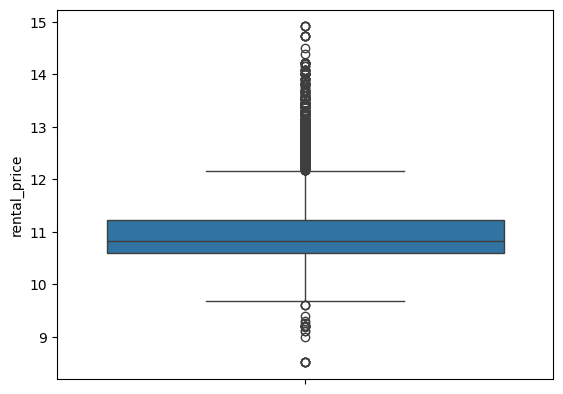

In [933]:
log_rental_price = np.log(df['rental_price'])

# Построить boxplot для логарифмированных значений цены
sns.boxplot(log_rental_price);

In [934]:
# количество объектов со стоимостью аренды менее 10000 руб.
len(df.loc[df['rental_price'] < 10000])

9

In [935]:
# количество объектв со стоимостью аренды более 1 000 000 руб.
len(df.loc[df['rental_price'] > 1000000])

53

In [936]:
# количество объектв со стоимостью аренды более 1 000 000 руб. в %
#(len(df.loc[df['rental_price'] > 1000000]) / all_obj) * 100

In [937]:
# удалим объекты стоимостью аренды более 1 000 000 руб. в %
# df = df.loc[df['rental_price'] < 1000000]
# print(f'Объектов после удаления: {df.shape[0]}')

In [938]:
df['deposit'].describe()

count     19737
mean      85974
std      135248
min        1000
25%       38000
50%       50000
75%       75000
max     4213000
Name: deposit, dtype: float64

In [939]:
all_obj = len(df)
all_obj 

19737

In [940]:
# количество объектов со стоимостью залога более 1 000 000 руб.
len(df.loc[df['deposit'] > 1000000])

59

In [941]:
# удалим объекты со стоимостью залога более 1 000 000 руб
# df = df.loc[df['deposit'] < 1000000]
# print(f'Объектов после удаления: {df.shape[0]}')

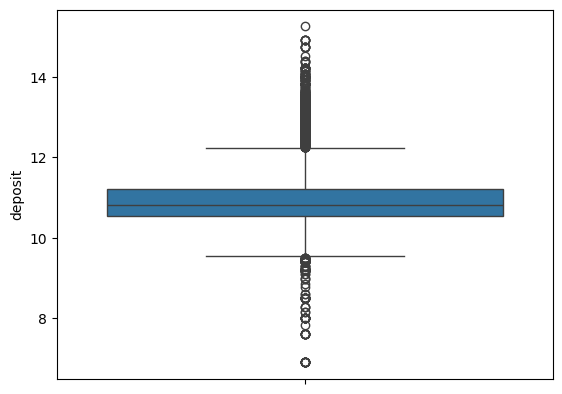

In [942]:
log_deposit = np.log(df['deposit'])

# Построить boxplot для логарифмированных значений цены
sns.boxplot(log_deposit);


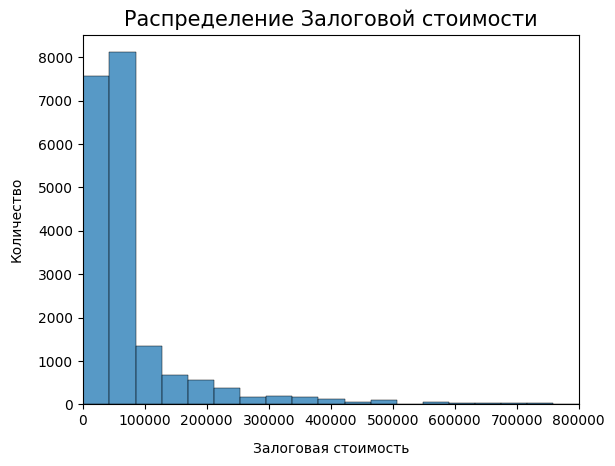

In [943]:
sns.histplot(data=df['deposit'], bins=100)
plt.title('Распределение Залоговой стоимости', fontsize=15)
plt.xlabel('Залоговая стоимость', labelpad=10, fontsize=10)
plt.ylabel('Количество', labelpad=10, fontsize=10)
plt.xlim(0, 800000)
plt.show();

In [944]:
df['log_deposit']= np.log(df['deposit'])
df['log_deposit']= np.log(df['rental_price'])

### Описание/description

In [945]:
df = df.drop(columns=['description'])

### Ремонт/ repair 

In [946]:
df['repair'].value_counts()

repair
Косметический    9824
Евроремонт       7004
Дизайнерский     2773
Без ремонта       136
Name: count, dtype: int64

In [947]:
def repair(val): #кодирование уникальных значений в соответствии со словарем и заполнение пропусков
    d = {'Дизайнерский':4, 'Евроремонт':3, 'Косметический':2, 'Без ремонта':1}
    return d[val]
# это для визуализации
repair_names = df['repair']

In [948]:
# заменяем имена на str
df['repair'] = df['repair'].apply(lambda x: repair(x))
df['repair'].value_counts()

repair
2    9824
3    7004
4    2773
1     136
Name: count, dtype: int64

In [949]:
# нормализуем значения
df['repair'] = (df['repair'] - df['repair'].min()) / (df['repair'].max() - df['repair'].min())

df['repair'].value_counts()

repair
0    9824
1    7004
1    2773
0     136
Name: count, dtype: int64

In [950]:

fig = px.box(x=df['rental_price'], y=repair_names)
fig.update_layout(
    xaxis_title="Rental Price",
    yaxis_title="Repair Type",
    title="Распределение стоимости аренды по типу ремонта"
)
fig.show()

In [951]:
# 3D Для визуализации взаимосвязи между ценой аренды, коэффициентом типа ремонта и стоимостью депозита
fig = go.Figure(data=[go.Scatter3d(
    x=df['rental_price'],
    y=df['repair'],
    z=df['deposit'],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',               
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Rental Price'),  # Название оси x
        yaxis=dict(title='Repair'),        # Название оси y
        zaxis=dict(title='Deposit'),       # Название оси z
    ),
    title='3D диаграмма рассеяния: Цена аренды, Ремонт и Депозит'
)

fig.show()

In [952]:
correlation_rent_deposit = df['rental_price'].corr(df['deposit'])
correlation_repair_deposit = df['repair'].corr(df['deposit'])
print("Корреляция между ценой аренды и стоимостью депозита:", correlation_rent_deposit)
print("Корреляция между коэффициентом типа ремонта и стоимостью депозита:", correlation_repair_deposit)

Корреляция между ценой аренды и стоимостью депозита: 0.973732048000096
Корреляция между коэффициентом типа ремонта и стоимостью депозита: 0.286935704493597


### Площадь комнаты / rooms_square

In [953]:
df['rooms_square'].value_counts()


rooms_square
20                1500
18                 736
19                 721
20.0               502
18.0               259
                  ... 
40-20-17-12          1
45-10-15-28-28       1
18 16 30 45          1
16-18-20-50          1
26,2+15,5-22,0       1
Name: count, Length: 3995, dtype: int64

In [954]:
df = df.drop(columns=['rooms_square'])

### Балкон/balcony

In [955]:
df['balcony'].unique()

array(['Лоджия (1)', 'Балкон (1)', 'Балкон (3)', 'Балкон (2), Лоджия (3)',
       'Балкон (1), Лоджия (1)', 'Балкон (2)', 'Лоджия (2)',
       'Балкон (3), Лоджия (3)', 'Балкон (3), Лоджия (1)', 'Лоджия (3)',
       'Балкон (1), Лоджия (2)', 'Балкон (2), Лоджия (1)',
       'Балкон (2), Лоджия (2)', 'Балкон (4)', 'Лоджия (4)',
       'Балкон (4), Лоджия (4)', 'Балкон (1), Лоджия (4)',
       'Балкон (1), Лоджия (3)'], dtype=object)

In [956]:
balcony = df['balcony'].str.split(',', expand=True) #разделяем по "," на две колонки, если есть и лоджии, и балконы 
        
x1 = balcony[0].str.split('(', expand=True)

x2 = balcony[1].str.split('(', expand=True)

combined = pd.concat([x1, x2], axis=1) #склеиваем 4 колонки

new_columns = ['Col1', 'Col2', 'Col3', 'Col4'] #переименовали колонки
combined = combined.set_axis(new_columns, axis=1)


In [957]:
combined['Col2'] = combined['Col2'].str.replace(')', '')
combined['Col4'] = combined['Col4'].str.replace(')', '') 

com1 = combined['Col1'].fillna('') + combined['Col3'].fillna('') 
com2 = combined['Col2'].fillna('').apply(lambda x: int(x) if x != '' else 0) + combined['Col4'].fillna('').apply(lambda x: int(x) if x != '' else 0) 

final = pd.concat([com1, com2], axis=1)
new_columns2 = ['balcony_loggia', 'balcony_count']
final = final.set_axis(new_columns2, axis=1)
final['balcony_loggia'] = final['balcony_loggia'].str.replace(' ', '')
final['balcony_loggia'].value_counts()

balcony_loggia
Лоджия          11771
Балкон           7283
БалконЛоджия      683
Name: count, dtype: int64

In [958]:

def balc(val):
    d = {'Балкон': 1, 'Лоджия': 2, 'БалконЛоджия': 3, '': 0}
    return d[val]

final['balcony_loggia'] = final['balcony_loggia'].fillna('').apply(lambda x: balc(x))
final['balcony_loggia'].isna().sum()

0

In [959]:
df['balcony'] = final['balcony_loggia']
df.rename(columns={'balcony': 'balcony_loggia'}, inplace=True)
df.columns.get_loc('balcony_loggia')
df['balcony_count'] = final['balcony_count'].values


### Приведение значений столбца 'windows' к числовым

In [960]:
#Сделаем 3 стобца с 1-если да, 0 -если нет
def code_windows(data, feature):
    for i in data[feature].unique():
        data[i] = (data[feature] == i).astype(float)

code_windows(df, 'windows')

In [961]:
def code_windows_2(row):
    if row['На улицу и двор'] == 1:
        row['На улицу'] = 1
        row['Во двор'] = 1
    return row

df = df.apply(code_windows_2, axis=1)

In [962]:
df.drop(['windows', 'На улицу и двор'], axis=1, inplace=True)

In [963]:
df.rename(columns={'Во двор': 'courtyard_view', 'На достопримечательность': 'landmark_view', 'На улицу': 'street_view'}, inplace=True)

# Приведение значений из столбца 'bathroom' к числовым

Вынесем в отдельные признаки общее количество сан. узлов в квартире и их вид

In [964]:
#Добавления столбца с количеством санузлов:
def bathroom_count(row):
    counts = re.findall(r'\d+', row)
    return sum(map(int, counts))

# Применяем функцию к столбцу "bathroom"
df['bathroom_count'] = df['bathroom'].apply(bathroom_count)



In [965]:
#Добавление столбцов с видом санузлов (совмещенный и раздельный)
def bathroom_kind(row):
    if 'Совмещенный' in row['bathroom'] and 'Раздельный' in row['bathroom']:
        row['combined_bath'] = 1
        row['separate_bath'] = 1
    elif 'Совмещенный' in row['bathroom']:
        row['combined_bath'] = 1
    elif 'Раздельный' in row['bathroom']:
        row['separate_bath'] = 1

    return row

df['combined_bath'] = np.nan
df['separate_bath'] = np.nan

df = df.apply(bathroom_kind, axis=1)
df.loc[:, ['combined_bath', 'separate_bath']] = df[['combined_bath', 'separate_bath']].fillna(0)

In [966]:
df.drop('bathroom', axis=1, inplace=True)

# Приведение столбца 'сhildren/pets_allowed' к численным значениям

Сделаем 2 столбца с наличием/отсутствием соответствующих признаков

In [967]:
df['сhildren/pets_allowed'].unique()

array(['Можно с детьми, Можно с животными', 'Можно с детьми',
       'Можно с животными', 'Нельзя никого'], dtype=object)

In [968]:
def bathroom_kind(row):
    if 'Можно с детьми' in row['сhildren/pets_allowed'] and 'Можно с животными' in row['сhildren/pets_allowed']:
        row['pets_allowed'] = 1
        row['children_allowed'] = 1
    elif 'Можно с детьм' in row['сhildren/pets_allowed']:
        row['children_allowed'] = 1
    elif 'Можно с животными' in row['сhildren/pets_allowed']:
        row['pets_allowed'] = 1

    return row

df['pets_allowed'] = np.nan
df['children_allowed'] = np.nan

df = df.apply(bathroom_kind, axis=1)
df.loc[:, ['pets_allowed', 'children_allowed']] = df[['pets_allowed', 'children_allowed']].fillna(0)

In [969]:
df.drop('сhildren/pets_allowed', axis=1, inplace=True)

# Приведение столбца 'additionally' к численным значениям

Добавим признаки наличия мебели и наличия крупной бытовой техники

In [970]:
df.additionally.unique()

array(['Мебель в комнатах, Мебель на кухне, Ванна, Душевая кабина, Стиральная машина, Кондиционер, Посудомоечная машина, Телевизор, Холодильник, Интернет, Телефон',
       'Мебель в комнатах, Мебель на кухне, Ванна, Душевая кабина, Стиральная машина, Кондиционер, Посудомоечная машина, Телевизор, Холодильник, Интернет',
       'Мебель в комнатах, Мебель на кухне, Ванна, Душевая кабина, Стиральная машина, Посудомоечная машина, Телевизор, Холодильник, Интернет',
       'Мебель в комнатах, Мебель на кухне, Ванна, Душевая кабина, Стиральная машина, Кондиционер, Посудомоечная машина, Телевизор, Холодильник',
       'Мебель в комнатах, Мебель на кухне, Ванна, Стиральная машина, Посудомоечная машина, Телевизор, Холодильник, Интернет, Телефон',
       'Мебель в комнатах, Мебель на кухне, Ванна, Душевая кабина, Стиральная машина, Кондиционер, Посудомоечная машина, Холодильник, Интернет',
       'Мебель на кухне, Ванна, Стиральная машина, Кондиционер, Посудомоечная машина, Телевизор, Холодильник,

In [971]:
def code_additionally(row):
    addition_furn = 'мебель'
    addition_tech = ['техника', 'холодильник', 'стиральная', 'посудомоечная']
    
    row['furniture'] = 1.0 if addition_furn in row['additionally'].lower() else 0
    row['home_tech'] = 1.0 if any(word in row['additionally'].lower() for word in addition_tech) else 0

    return row


df['furniture'] = np.nan
df['home_tech'] = np.nan

df = df.apply(code_additionally, axis=1)

In [972]:
df.drop('additionally', axis=1, inplace=True)

In [973]:
vera_df = df.loc[:, 'courtyard_view': 'home_tech']

In [974]:
vera_df

,courtyard_view,landmark_view,street_view,bathroom_count,combined_bath,separate_bath,pets_allowed,children_allowed,furniture,home_tech
0,1,0,0,2,1,0,1,1,1,1
1,1,0,1,3,1,1,0,1,1,1
2,1,0,1,3,1,0,0,1,1,1
3,1,0,1,3,1,0,1,0,1,1
4,1,0,1,2,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
19732,1,0,0,1,1,0,1,0,1,1
19733,1,0,0,1,1,0,1,0,1,1
19734,1,0,1,1,1,0,0,1,1,1
19735,1,0,0,2,1,1,0,1,1,1


In [975]:
# vera_df.to_csv('../notebooks/vera_df.csv')

### 

In [976]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [977]:
df = pd.read_csv('../release/data.csv')
df.columns

Index(['id', 'rooms', 'adress', 'area', 'building', 'parking', 'price',
       'description', 'repair', 'rooms_square', 'balcony', 'windows',
       'bathroom', 'сhildren/pets_allowed', 'additionally', 'housing_complex',
       'ceiling_height', 'elevator', 'garbage_chute', 'floor_count'],
      dtype='object')

In [978]:
my_df = df.iloc[:,:6]

In [979]:
my_df.head()

,id,rooms,adress,area,building,parking
0,271271157,4,"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная
1,271634126,4,"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная
2,271173086,"4, Оба варианта","Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная
3,272197456,"4, Оба варианта","Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная
4,273614615,2,"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",Unknown


In [980]:
my_df['rooms_number'] = my_df['rooms'].apply(lambda x: int(x.split(', ')[0]) if len(x) > 1 else int(x))

In [981]:
my_df['layout'] = my_df['rooms'].apply(lambda x: x.split(', ')[1] if len(x) > 1 else 'Unknown')

In [982]:
my_df['price'] = df['price'].apply(lambda x: int(x.split('.')[0]))

In [983]:
def set_currency(x):
    if '€' in x:
        return 'eur'
    elif '$' in x:
        return 'usd'
    elif 'руб' in x:
        return 'rub'
    else:
        return 'other'

In [984]:
my_df['currency'] = df['price'].apply(set_currency)

In [985]:
my_df.groupby('currency').size()

currency
eur        9
rub    19714
usd       14
dtype: int64

In [986]:
my_df.loc[my_df['currency'] == 'eur', 'price'] = (my_df.loc[my_df['currency'] == 'eur', 'price'] * 100.07).astype(int)
my_df.loc[my_df['currency'] == 'usd', 'price'] = (my_df.loc[my_df['currency'] == 'usd', 'price'] * 92.48).astype(int)

In [987]:
my_df['price'].describe()

count     19737
mean      87851
std      134420
min       12000
25%       40000
50%       50000
75%       75000
max     3000000
Name: price, dtype: float64

In [988]:
# Удалим ненужные столбцы

my_df = my_df.drop(columns=['rooms', 'currency'])

In [989]:
# Теперь можно проверить как связана планировка со стоимостью аренды

In [990]:
my_df.groupby('layout').agg({'price': ['count', 'median']})

price       
               count median
layout                     
Unknown        11770  45000
Изолированная   5803  55000
Оба варианта    1492  85000
Смежная          672  45000

In [991]:
# Применяем target encoding к категориальной переменной btype
median_price_per_layout = my_df.groupby('layout')['price'].median()

# Создадим словарь, сопоставляющий категории building_type с их медианными значениями цены
layout_median_price_map = median_price_per_layout.to_dict()

# Заменим значения в столбце building_type на их медианные значения цены
my_df['layout'] = my_df['layout'].map(layout_median_price_map)

In [992]:
my_df['area'] = my_df['area'].apply(lambda x: int(float(x.split('/')[0])) if len(x.split('/')) > 1 else int(float(x)))

In [993]:
my_df.head(1)

,id,adress,area,building,parking,rooms_number,layout,price
0,271271157,"Москва, улица Новый Арбат, 27",200,"5/16, Монолитный",подземная,4,45000,500000


In [994]:
my_df['btype'] = my_df['building'].apply(lambda x: x.split(', ')[1] if len(x.split(', ')) > 1 else 'Unknown')

In [995]:
my_df.groupby('btype').size().sort_values(ascending=False)

btype
Панельный              6679
Кирпичный              3696
Монолитный             3615
Unknown                2971
Блочный                1689
Монолитно-кирпичный     872
Сталинский              141
старый фонд              68
Деревянный                5
Щитовой                   1
dtype: int64

In [996]:
my_df.groupby('btype').agg({'price': ['mean', 'median', 'count']})

price             
                      mean median count
btype                                  
Unknown             139597  57000  2971
Блочный              45096  40000  1689
Деревянный           79000  35000     5
Кирпичный            82055  55000  3696
Монолитно-кирпичный 198497 120000   872
Монолитный          116255  70000  3615
Панельный            46591  43000  6679
Сталинский          113957  95000   141
Щитовой              45000  45000     1
старый фонд         274853 210000    68

In [997]:
# Применяем target encoding к категориальной переменной btype
median_price_per_building_type = my_df.groupby('btype')['price'].median()

# Создадим словарь, сопоставляющий категории building_type с их медианными значениями цены
building_type_median_price_map = median_price_per_building_type.to_dict()

# Заменим значения в столбце building_type на их медианные значения цены
my_df['btype'] = my_df['btype'].map(building_type_median_price_map)

In [998]:
# Выделим этаж, на которой находится квартра и общую этажность дома в отдельные столбцы
my_df['floor'] = my_df['building'].apply(lambda x: int(x.split(', ')[0].split('/')[0]) if len(x.split(', ')) > 1 else int(x.split('/')[0]))
my_df['total_floors'] = my_df['building'].apply(lambda x: int(x.split(', ')[0].split('/')[1]) if len(x.split(', ')) > 1 else int(x.split('/')[1]))

In [999]:
my_df.drop(columns='building', inplace=True)
my_df.head()

,id,adress,area,parking,rooms_number,layout,price,btype,floor,total_floors
0,271271157,"Москва, улица Новый Арбат, 27",200,подземная,4,45000,500000,70000,5,16
1,271634126,"Москва, улица Новый Арбат, 27",198,подземная,4,45000,500000,120000,5,16
2,271173086,"Москва, улица Новый Арбат, 27",200,подземная,4,85000,500000,57000,5,16
3,272197456,"Москва, переулок Плотников, 21С1",170,подземная,4,85000,400000,57000,5,6
4,273614615,"Москва, улица Новый Арбат, 15",58,Unknown,2,45000,225000,43000,12,26


In [1000]:
# Поделим total_floors на квантили
my_df['total_floors_quantile'] = pd.qcut(my_df['total_floors'], q=5, labels=False)

In [1001]:
# Применяем target encoding к квантилям total_floors
mean_price_per_total_floors_quantile = my_df.groupby('total_floors_quantile')['price'].mean()

# Создадим словарь, сопоставляющий категории building_type с их медианными значениями цены
total_floors_quantile_mean_price_map = mean_price_per_total_floors_quantile.to_dict()

# Заменим значения в столбце building_type на их медианные значения цены
my_df['total_floors_quantile'] = my_df['total_floors_quantile'].map(total_floors_quantile_mean_price_map)

In [1002]:
# Сделаем то же самое с этажностью здания
my_df['floor_quantile'] = pd.qcut(my_df['floor'], q=5, labels=False)

In [1003]:
# Применяем target encoding к квантилям floor
mean_price_per_floor_quantile = my_df.groupby('floor_quantile')['price'].mean()

# Создадим словарь, сопоставляющий категории building_type с их медианными значениями цены
floor_quantile_mean_price_map = mean_price_per_floor_quantile.to_dict()

# Заменим значения в столбце building_type на их медианные значения цены
my_df['floor_quantile'] = my_df['floor_quantile'].map(floor_quantile_mean_price_map)

In [1004]:
my_df.drop(columns=['floor', 'total_floors'], inplace=True)

In [1005]:
my_df.head(1)

,id,adress,area,parking,rooms_number,layout,price,btype,total_floors_quantile,floor_quantile
0,271271157,"Москва, улица Новый Арбат, 27",200,подземная,4,45000,500000,70000,68621,95289


In [1006]:
my_df['has_parkin'] = my_df['parking'].apply(lambda x: 0 if x == 'Unknown' else 1)
my_df.groupby('has_parkin').agg({'price': ['mean', 'median', 'count']})

price              
            mean median  count
has_parkin                    
0          79463  45000  11174
1          98796  55000   8563

In [1007]:
# Для обучения модели оставим бинарный признак, а изначальный столбец удалим

In [1008]:
my_df.drop(columns=['parking', 'adress'], inplace=True)

In [1009]:
my_df = my_df.set_index('id')

In [1010]:
my_df.head(5)

,area,rooms_number,layout,price,btype,total_floors_quantile,floor_quantile,has_parkin
id,,,,,,,,
271271157,200,4,45000,500000,70000,68621,95289,1
271634126,198,4,45000,500000,120000,68621,95289,1
271173086,200,4,85000,500000,57000,68621,95289,1
272197456,170,4,85000,400000,57000,128076,95289,1
273614615,58,2,45000,225000,43000,104609,94374,0


In [1011]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19737 entries, 271271157 to 274672243
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   19737 non-null  int64  
 1   rooms_number           19737 non-null  int64  
 2   layout                 19737 non-null  float64
 3   price                  19737 non-null  int64  
 4   btype                  19737 non-null  float64
 5   total_floors_quantile  19737 non-null  float64
 6   floor_quantile         19737 non-null  float64
 7   has_parkin             19737 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 1.4 MB


In [1012]:
df.to_csv('igor.csv', index=False)

In [1013]:
# Возвращаею потерявшийся столбец
df_metro = pd.read_csv('../data/_data.csv')
df_metro = df_metro.set_index('ID  объявления')

In [1014]:
my_df['metro'] = df_metro['Метро']

In [1015]:
my_df['metro'] = my_df['metro'].apply(lambda x: x.split(' (')[0] if isinstance(x, str) else 'Unknown')

In [1016]:
my_df.groupby('metro').size().sort_values(ascending=False)

metro
м. Селигерская     393
Unknown            346
м. Щелковская      313
м. Бабушкинская    284
м. Новогиреево     282
                  ... 
м. Нахабино          1
м. Лужники           1
м. Румянцево         1
м. Яхромская         1
м. Театральная       1
Length: 278, dtype: int64

In [1017]:
# Применяем target encoding к metro
mean_price_per_metro = my_df.groupby('metro')['price'].mean()

# Создадим словарь, сопоставляющий категории metro с их средними значениями цены
metro_mean_price_map = mean_price_per_metro.to_dict()

# Заменим значения в столбце metro на их средние значения цены
my_df['metro'] = my_df['metro'].map(metro_mean_price_map)

In [1018]:
my_df

,area,rooms_number,layout,price,btype,total_floors_quantile,floor_quantile,has_parkin,metro
id,,,,,,,,,
271271157,200,4,45000,500000,70000,68621,95289,1,313197
271634126,198,4,45000,500000,120000,68621,95289,1,313197
271173086,200,4,85000,500000,57000,68621,95289,1,313197
272197456,170,4,85000,400000,57000,128076,95289,1,313197
273614615,58,2,45000,225000,43000,104609,94374,0,340904
...,...,...,...,...,...,...,...,...,...
215565511,35,1,45000,42000,57000,68621,72970,0,57379
274654844,38,1,45000,45000,70000,64310,95289,0,46280
268679909,43,2,85000,50000,55000,128076,95289,0,46280


In [1019]:
df.to_csv('../release/data.csv', index=False)

In [1020]:
df.columns

Index(['id', 'rooms', 'adress', 'area', 'building', 'parking', 'price',
       'description', 'repair', 'rooms_square', 'balcony', 'windows',
       'bathroom', 'сhildren/pets_allowed', 'additionally', 'housing_complex',
       'ceiling_height', 'elevator', 'garbage_chute', 'floor_count'],
      dtype='object')

In [1025]:
df.head()

,id,rooms,adress,area,building,parking,price,description,repair
0,271271157,4,"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский
1,271634126,4,"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский
2,271173086,"4, Оба варианта","Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт
3,272197456,"4, Оба варианта","Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт
4,273614615,2,"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",Unknown,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт


In [1021]:
df=df.drop(columns=['rooms_square', 'balcony', 'windows', 'bathroom', 'сhildren/pets_allowed', 'additionally', 'housing_complex', 'ceiling_height', 'elevator', 'garbage_chute', 'floor_count'])

In [ ]:
df